# Model Training Notebook

A simple notebook that is used to train the prophet model to perform inference and forecasting on this dataset.

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from itertools import product
from prophet.serialize import model_to_json
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

/home/tea/.cache/pypoetry/virtualenvs/dps-ai-challenge-1GO35zOW-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# load data
DATA_DIR = '../data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'

data = pd.read_csv(DATA_DIR)
data.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


In [3]:
# preprocess data
# helper function 1
def convert_Monat_to_Months(value):
    try:
        int(value)
        return value[-2:]
    except ValueError:
        return np.nan

# main preprocess, replicating steps from the EDA file.
def preprocess_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.iloc[:, :5] # remove unneeded columns
    df = df[(df['AUSPRAEGUNG'] == 'insgesamt') & (df['MONATSZAHL'] == 'Alkoholunfälle')] # filter data to challenge constraints
    df['MONAT'] = df['MONAT'].apply(convert_Monat_to_Months) # filter months to create year-month pairs
    df.dropna(inplace=True, axis=0)
    df['TIMESTAMP'] = pd.to_datetime(df["JAHR"].astype(str) + df["MONAT"], format='%Y%m')
    df = df.sort_values('TIMESTAMP')
    train = df[df['JAHR'] <= 2020].reset_index(drop=True)[['TIMESTAMP', 'WERT']].rename({'TIMESTAMP': 'ds', 'WERT': 'y'}, axis='columns')
    test = df[df['JAHR'] > 2020].reset_index(drop=True)[['TIMESTAMP', 'WERT']].rename({'TIMESTAMP': 'ds', 'WERT': 'y'}, axis='columns')
    return (train, test)

In [4]:
# run preprocessing
train_data, test_data = preprocess_data(data)

print(f"""
Number of training samples: {train_data.shape[0]}
Number of testing samples: {test_data.shape[0]}
""")


Number of training samples: 252
Number of testing samples: 24



In [5]:
train_data.head()

,ds,y
0,2000-01-01,78.0
1,2000-02-01,53.0
2,2000-03-01,73.0
3,2000-04-01,78.0
4,2000-05-01,96.0


In [6]:
test_data.head()

,ds,y
0,2021-01-01,16.0
1,2021-02-01,14.0
2,2021-03-01,24.0
3,2021-04-01,16.0
4,2021-05-01,24.0


In [ ]:
# Perform hyperparameter tuning using built-in prophet methods.
# parameter grid
param_grid = {
    'growth': ['linear', 'flat'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2, 0.5],
    'seasonality_prior_scale': [1.0, 2.0, 5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmses = []

print(f"Iterating over {len(all_params)} sets of parameters...")
# use cross-validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_data)
    cv_dataframe = cross_validation(m, horizon='365 days', parallel="threads")
    results = performance_metrics(cv_dataframe, rolling_window=1)
    rmses.append(results['rmse'].iloc[0])

The output of the above cell was removed because it was too much spam.

In [8]:
len(all_params)

400

In [9]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Identify the best parameters
best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]
print(f"Best parameters:\n{best_params}")

tuning_results.sort_values('rmse').head()

Best parameters:
growth                             linear
changepoint_prior_scale               0.2
seasonality_prior_scale               1.0
seasonality_mode           multiplicative
yearly_seasonality                   True
weekly_seasonality                  False
rmse                             8.705898
Name: 125, dtype: object


,growth,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,yearly_seasonality,weekly_seasonality,rmse
125,linear,0.2,1.0,multiplicative,True,False,8.705898
165,linear,0.5,1.0,multiplicative,True,False,8.729012
85,linear,0.1,1.0,multiplicative,True,False,8.734995
133,linear,0.2,2.0,multiplicative,True,False,8.860329
173,linear,0.5,2.0,multiplicative,True,False,8.861568


In [13]:
# make a model that has the best performance out of all
predictor = Prophet(**best_params.drop(['rmse', 'yearly_seasonality', 'weekly_seasonality'])).fit(train_data)
y_hat = predictor.predict(test_data)['yhat']
y = test_data['y']
print(f"""
Test Data Results
Mean Absolute Error: {mean_absolute_error(y, y_hat)},
Root Mean Square Error: {root_mean_squared_error(y, y_hat)},
R2 Score: {r2_score(y, y_hat)}
""")

21:25:21 - cmdstanpy - INFO - Chain [1] start processing
21:25:21 - cmdstanpy - INFO - Chain [1] done processing



Test Data Results
Mean Absolute Error: 7.863451865241231,
Root Mean Square Error: 9.552909667483597,
R2 Score: 0.5537502048161292



In [14]:
with open("../models/prophet-model.json", "w") as fout:
    fout.write(model_to_json(predictor))

This model can be imported and used in the API

## Plotting y_hat and y

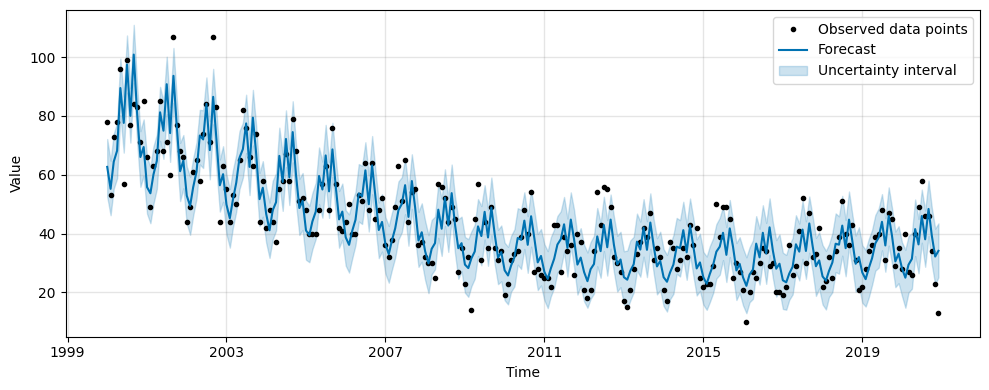

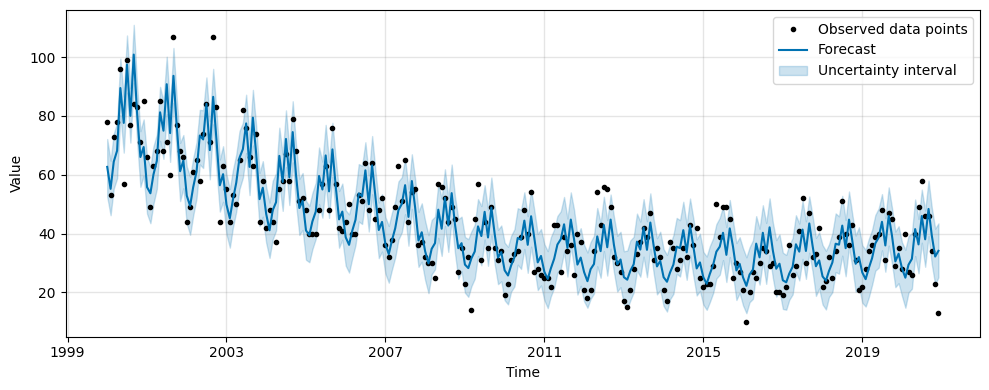

In [23]:
from prophet.plot import plot
plot(predictor, predictor.predict(train_data), xlabel='Time', ylabel='Value', figsize=(10, 4), include_legend=True)